## This notebook constructs the GRAND dam network using the Free-Flow Rivers Dataset (Grill et al., 2019)

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import networkx as nx
import time

### Load Free-Flowing Rivers (Grill et al., 2019)

In [2]:
# *The original gdb data is too large to deploy
# gdf = gpd.read_file('/Users/dlee/data/ffr_network/dlee/subset.dbf')
# df = gdf[gdf.columns[:-1]]
# df.to_hdf('/Users/dlee/data/ffr_network/dlee/ffr_network.hdf', 'df', complib='blosc:zstd', complevel=9)
ffr = pd.read_hdf('/Users/dlee/data/ffr_network/dlee/ffr_network.hdf',key='df')

# Dam shapefile and Degree of Regulation (DOR)
df_dam = gpd.read_file('./data/granddams_eval.shp')
df_dor = pd.read_hdf('./data/df_dor.hdf')
ffr.head()

,NOID,NUOID,NDOID,LENGTH_KM,UPLAND_SKM,DIS_AV_CMS,DOR
0,1,None,0,0.888,11.097,0.062,0.0
1,2,None,0,2.904,24.246,0.126,0.0
2,3,None,9,4.633,57.225,0.316,0.0
3,4,None,9,0.695,11.110,0.061,0.0
4,5,None,0,8.317,33.992,0.177,0.0


### Generate a network of GRAND dams showing downstream and outlet reservoirs

In [3]:
fn_network = './data/grand_network_ffr.hdf'
if not os.path.exists(fn_network):
    t0 = time.time()
    network = df_dor.reset_index().drop(['DOR','DOF','CAP_MCM'], axis=1)
    network['prev'] = network['NOID'].values
    network['next'] = np.NaN
    network['to'] = np.NaN
    network['length'] = 0
    # Initialize negative reach length
    con, ind1, ind2 = np.intersect1d( network['prev'], ffr['NOID'], return_indices=True)
    temp_length = ffr.loc[ind2, 'LENGTH_KM'].values
    for i, loc in enumerate(con):
        network.loc[network['prev']==loc,'length'] = -temp_length[i]
    result = network.copy().set_index('GRAND_ID')
    # network = network[np.isin(network['GRAND_ID'], [24,25,27])]
    print(network.shape[0])

    # Loop of the network finding algorithm
    while network.shape[0] > 0:
        # Find downstream index and reach length
        con, ind1, ind2 = np.intersect1d( network['prev'], ffr['NOID'], return_indices=True)
        temp_down = ffr.loc[ind2, 'NDOID'].values
        temp_length = ffr.loc[ind2, 'LENGTH_KM'].values
        for i, loc in enumerate(con):
            network.loc[network['prev']==loc,'next'] = temp_down[i]
            network.loc[network['prev']==loc,'length'] += temp_length[i]

        # Check downstream is the dam
        con = np.intersect1d(result['NOID'], network['next'])
        for loc in con:
            network.loc[network['next'] == loc, 'to'] = result[result['NOID'] == loc].index[0]
        # Check downstream is the outlet
        network.loc[network['next'] == 0, 'to'] = -network.loc[network['next'] == 0, 'prev'].values   # outlet (-gridid)

        # Store the connected dams
        if network['to'].notna().sum() > 0:
            right = network.loc[network['to'].notna(), ['GRAND_ID','prev','next','to','length']].set_index('GRAND_ID')
            result.update(right)

        # Exclude connected dams from the network DataFrame
        network = network[network['to'].isna()].reset_index(drop=True)
        # Exchange grid indices
        network['prev'] = network['next'].copy().values
        network['next'] = np.NaN    
    print('%.2fs took' % (time.time() - t0))
    # Save the result
    result.to_hdf(fn, key='df')
    print('%s is saved.' % fn_network)
else:
    result = pd.read_hdf(fn_network)
    print('%s is loaded.' % fn_network)

result = result.reset_index()
result.head()

./data/grand_network_ffr.hdf is loaded.


,GRAND_ID,NOID,prev,next,to,length
0,6,8325693,8061209.0,0.0,-8061209.0,3756.791
1,15,7160040,7313582.0,0.0,-7313582.0,1067.181
2,24,7284129,7283186.0,0.0,-7283186.0,13.750
3,25,7284780,7284259.0,7284129.0,24.0,15.034
4,27,7288853,7288853.0,0.0,-7288853.0,0.000


### Degree of Regulation (DOR)

In [4]:
fn_newdor = './data/new_dor.hdf'
if not os.path.exists(fn_newdor):
    spec = df_dor.reset_index().drop(['DOF'], axis=1).rename(columns={'DOR':'DOR1'})
    spec['DOR2'] = np.NaN
    spec = spec[['GRAND_ID', 'NOID', 'DOR1', 'DOR2', 'CAP_MCM']]
    for _, row in spec[['GRAND_ID', 'NOID']].iterrows():
        gid = row['GRAND_ID']
        nuoid = ffr.loc[ffr['NOID']==row['NOID'],'NUOID'].values
        if nuoid:
            # There are upstream reaches
            nuoid = [int(i) for i in nuoid[0].split('_')]
            temp = ffr.loc[ffr['NOID'].isin(np.array(nuoid)), ['DIS_AV_CMS','DOR']]
            av_dor = np.sum(temp['DIS_AV_CMS'] * temp['DOR']) / temp['DIS_AV_CMS'].sum()
        else:
            # No upstream reaches (headwater dam)
            av_dor = 0
        spec.loc[spec['GRAND_ID']== gid, 'DOR2']  = av_dor
    # save new dor
    spec.to_hdf(fn_newdor, key='df')
    print('%s is saved.' % fn_newdor)
else:
    # Load new DOR
    spec = pd.read_hdf(fn_newdor)
    print('%s is loaded.' % fn_newdor)
spec.head()

./data/new_dor.hdf is loaded.


,GRAND_ID,NOID,DOR1,DOR2,CAP_MCM
0,6,8325693,100.000000,0.000000,74300.0
1,15,7160040,100.000000,0.000000,23800.0
2,24,7284129,50.760059,37.927695,320.7
3,25,7284780,40.613804,0.000000,1002.8
4,27,7288853,98.974724,0.000000,1620.0


### Load GRAND dam specification variables

In [5]:
# Load Jia's regression variables
df_var = pd.read_hdf('./data/regression_variables.hdf').reset_index()
# Merge DataFrames
data = result.merge(spec[['GRAND_ID', 'DOR1', 'DOR2', 'CAP_MCM']], how='inner', on='GRAND_ID')
data = data.merge(df_var[['GRAND_ID','ECAP']], how='inner', on='GRAND_ID')

# Save the result for Jia
temp = data.copy()
temp= temp[['GRAND_ID','to','length','DOR2','CAP_MCM','ECAP']]
temp = temp.rename(columns={'to':'DOWN_GRAND_ID', 
                            'length':'LENGTH_TO_DOWN_GRAND_ID_KM',
                            'DOR2':'DOR'})
if False: temp.to_csv('./data/new_dor_200514.csv'); print("%s is saved." % './data/new_dor_200514.csv')
data.head()

,GRAND_ID,NOID,prev,next,to,length,DOR1,DOR2,CAP_MCM,ECAP
0,6,8325693,8061209.0,0.0,-8061209.0,3756.791,100.000000,0.000000,74300.0,2730.0
1,15,7160040,7313582.0,0.0,-7313582.0,1067.181,100.000000,0.000000,23800.0,890.0
2,24,7284129,7283186.0,0.0,-7283186.0,13.750,50.760059,37.927695,320.7,47.0
3,25,7284780,7284259.0,7284129.0,24.0,15.034,40.613804,0.000000,1002.8,65.0
4,27,7288853,7288853.0,0.0,-7288853.0,0.000,98.974724,0.000000,1620.0,46.0


### Plotting the number of GRAND dams according to DOR value

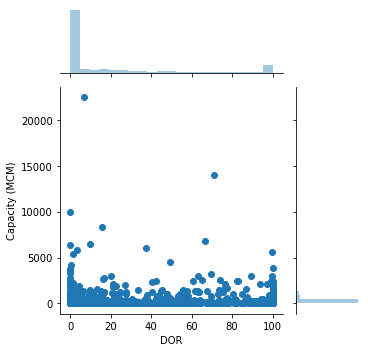

DOR <= 0:  735 Dams (46%) with 10% of global ECAP
DOR <= 30: 1211 Dams (76%) with 23% of global ECAP
DOR <= 50: 1321 Dams (82%) with 26% of global ECAP
DOR <= 70: 1401 Dams (87%) with 29% of global ECAP
DOR <= 90: 1459 Dams (91%) with 33% of global ECAP
DOR <= 100: 1593 Dams (100%) with 38% of global ECAP


In [6]:
# Scatterplot of DOR and CAP_MCM
ax = sns.jointplot(x="DOR2", y="ECAP", data=data,height=5, ratio=3)
ax.set_axis_labels(xlabel='DOR', ylabel='Capacity (MCM)')
plt.show()
# Number of dams according to the DOR threshold
ECAP_TOTAL = 1292000    # 1,292 GW (IHA, 2018)
thresholds = [0, 30, 50, 70, 90, 100]
for thsd in thresholds:
    safe = data['DOR2'] <= thsd
    print('DOR <= %d: %4d Dams (%d%%) with %d%% of global ECAP' % 
          (thsd, safe.sum(), safe.sum()/1593*100, data[safe].ECAP.sum()/ECAP_TOTAL*100))

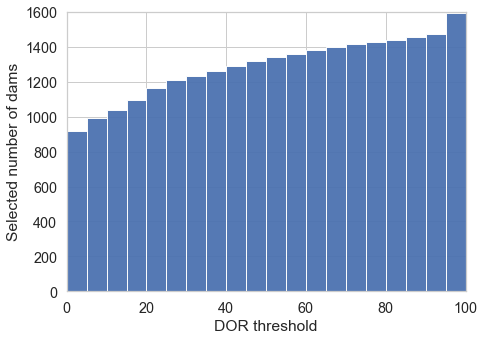

./figures/ndam_dor.png is saved.


In [7]:
# Scatterplot of DOR and CAP_MCM
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax = sns.distplot(data['DOR2'], color='b', bins=20,
                  hist_kws={'cumulative': True, 'alpha':0.95}, kde=False)
ax.set_ylabel('Selected number of dams')
ax.set_xlabel('DOR threshold')
ax.set_xlim([0, 100])
ax.set_ylim([0, 1600])
plt.tight_layout()
plt.show()
# Save a figure
if True:
    fn_save = './figures/ndam_dor.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Check grid adjustment of 1593 (735) dams

In [23]:
adj = pd.read_excel('./data/grand1593_newInflowsR2_dlee.xlsx',sheet_name='R')
adj = adj.loc[adj.GRID_ADJ == 'Yes','GRAND_ID'].reset_index(drop=True)
num_adj_of_735 = np.isin(data[data.DOR2 == 0].GRAND_ID, adj).sum()
num_adj_of_735

270

### Initialize mapping parameters

In [12]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
from tools import cbarpam, GDFPlotOrder
# Load 1593 GranD dam shapefile
gdfDam = gpd.read_file('./data/granddams_eval.shp')
gdfDam = gdfDam.drop(gdfDam.columns[1:-1], axis=1)
# Load world base map (exclude Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
# Reprojection to Robinson projection (ESRI:54030)
lims = [-135, 167, -55, 80]
if True:
    inProj = Proj(init="epsg:4326")
    outProj = Proj(init="esri:54030")
    world = world.to_crs({'init':'esri:54030'})
    gdfDam = gdfDam.to_crs({'init':'esri:54030'})
    xmin, _ = transform(inProj, outProj, lims[0], 0)
    xmax, _ = transform(inProj, outProj, lims[1], 0)
    _, ymin = transform(inProj, outProj, 0, lims[2])
    _, ymax = transform(inProj, outProj, 0, lims[3])
lims = [xmin, xmax, ymin, ymax]

### Mapping GRAND dams according to DOR
This is for checking their geographical distribution.

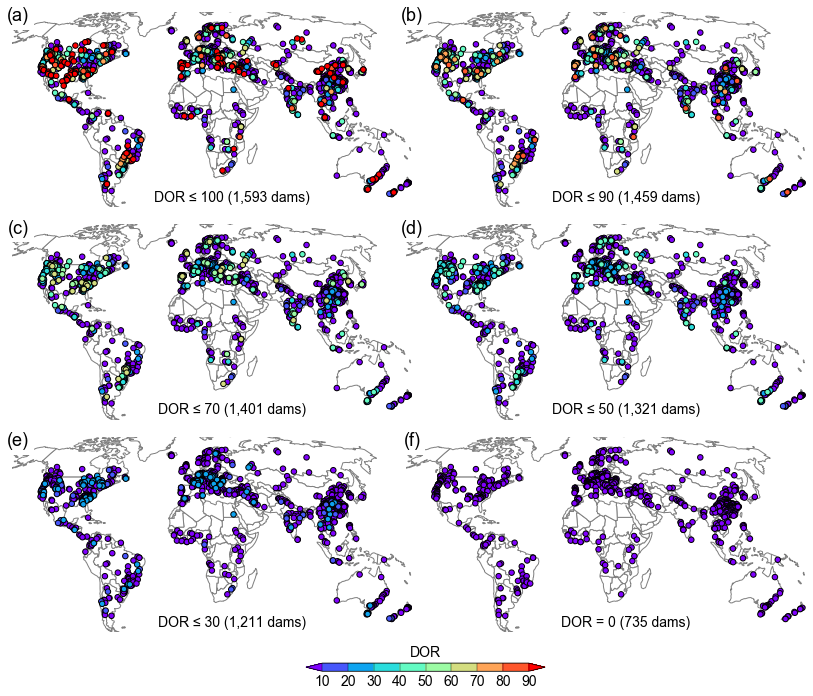

In [15]:
damMap = gdfDam.merge(data, on='GRAND_ID')
# Colormap
bounds = list(np.arange(0.1,1.0,0.1)*100)
boundaries = [-10]+bounds+[100]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'rainbow', labloc='in',
                                                    boundaries=boundaries, extension='both')
# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['']
fignumb = ['(a)', '(b)', '(c)', '(d)','(e)','(f)']
thresholds = [100,90,70,50,30,0]

for (i, thsd) in enumerate(thresholds):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    tempMap = damMap[damMap['DOR2']<=thsd]
    GDFPlotOrder(tempMap, boundaries, ax, 'DOR2',
                cmap, norm, vmin, vmax, order='seq')
    ax.annotate(fignumb[i], xy=(0.015, 0.98), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
    anot = 'DOR ≤ {} ({:,} dams)'.format(thsd, tempMap.shape[0])
    if i in [5]: anot = 'DOR = {} ({:,} dams)'.format(thsd, tempMap.shape[0])
    ax.annotate(anot, xy=(0.55, 0.05), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=14, backgroundcolor="w")
plt.tight_layout(w_pad=-5)
# Colorbar
cax = inset_axes(ax,
                 width="46%",
                 height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.25, -0.2, 1.3, 1.4),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = bounds,
                                 spacing='uniform',
                                 orientation='horizontal',
                                 drawedges=True)
cbar.ax.set_xticklabels(['%d'%lab for lab in bounds], 
                        fontname='arial', fontsize=14)
cbar.ax.tick_params(length=0)
cbar.outline.set_edgecolor('black')
cbar.set_label('DOR', labelpad=-43, 
               fontname='arial', fontsize=14, 
               horizontalalignment='center')
plt.show()

# Save a figure
if False:
    fn_save = './figures/dam_dor.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### GRAND dam network map

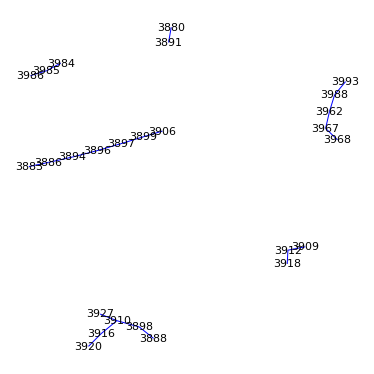

In [269]:
temp = data.copy()
temp = temp.sort_values('to', ascending=False)
temp = temp.iloc[280:300]
temp['to'] = temp['to'].astype(int)


# Build your graph
G=nx.from_pandas_edgelist(temp, source='GRAND_ID', target='to')

# Plot it
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels='to', font_size = 11, node_color='None', edge_color='blue', )
# plt.tight_layout()
plt.show()
# https://networkx.github.io/documentation/stable/tutorial.html
# https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial
# https://towardsdatascience.com/catching-that-flight-visualizing-social-network-with-networkx-and-basemap-ce4a0d2eaea6